# Clustering analysis

This notebook contains attempts at unsupervised learning for a dataset containing audio features for 30,000 songs obtained from the Spotify API.

The goal is to identify natural groupings in the data, such that we can classify songs into moods based on their audio features.

Dataset: [30,000 Spotify songs](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)

In [26]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import warnings
import umap.umap_ as umap

path_to_csv = '30000-spotify-songs/spotify_songs.csv'

In [7]:
# Load dataset

tracks_df = pd.read_csv(path_to_csv)
tracks_df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


Each track has the following features associated with it:

| Variable | Type | Description |
|----------|------|-------------|
| track_id | character | Song unique ID |
| track_name | character | Song Name |
| track_artist | character | Song Artist |
| track_popularity | double | Song Popularity (0-100) where higher is better |
| track_album_id | character | Album unique ID |
| track_album_name | character | Song album name |
| track_album_release_date | character | Date when album released |
| playlist_name | character | Name of playlist |
| playlist_id | character | Playlist ID |
| playlist_genre | character | Playlist genre |
| playlist_subgenre | character | Playlist subgenre |
| danceability | double | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | double | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| key | double | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| loudness | double | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| mode | double | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| speechiness | double | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| acousticness | double | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| instrumentalness | double | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | double | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| valence | double | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | double | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| duration_ms | double | Duration of song in milliseconds |

The features used to identify the tracks are not relevant for our analysis, so they can be dropped.

We are choosing to drop the genre features (`playlist_genre`, `playlist_subgenre`) as well. The reason for this is that our aim is to find natural grouping based solely on audio features, without having the genre influence our decisions. Inlcuding the genre will most likely lead to songs with similar genres being grouped together, regardless of the mood they evoke.

We are also choosing to drop `duration_ms`, as it is unlikely to affect the mood of a song.

In [8]:
track_features_df = tracks_df.drop(['track_id', 
                                   'track_name', 
                                   'track_artist', 
                                   'track_popularity', 
                                   'track_album_id', 
                                   'track_album_name', 
                                   'track_album_release_date', 
                                   'playlist_name', 
                                   'playlist_id', 
                                   'playlist_genre', 
                                   'playlist_subgenre',
                                   'duration_ms'], axis=1)

track_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976


Lets first normalize these features.

Lets standardize these features.

In [27]:
scaler = MinMaxScaler()
scaled_track_feat_df = pd.DataFrame(scaler.fit_transform(track_features_df), columns=track_features_df.columns)
scaled_track_feat_df.head()
X = scaled_track_feat_df.values

Lets now compute variances for each feature,this can tell us if there are any uninformative features (i.e. low variance).

mode                0.245690
key                 0.107802
valence             0.055349
instrumentalness    0.050888
acousticness        0.048823
energy              0.032740
liveness            0.024005
danceability        0.021784
tempo               0.012625
speechiness         0.012180
loudness            0.003921
dtype: float64


Text(0.5, 1.0, 'Variance Analysis')

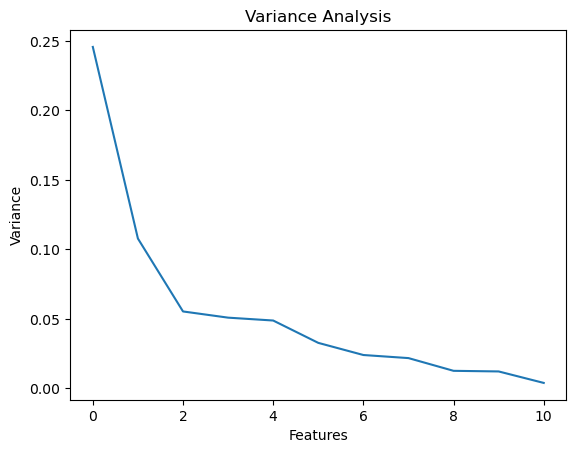

In [32]:
variances = pd.DataFrame(scaled_track_feat_df, columns=scaled_track_feat_df.columns).var().sort_values(ascending=False)
print(variances)
plt.plot(variances.values)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance Analysis')

As we can see, the loudness feature has very low variance (0.0039) i.e. it is a good candidate for removal.

In [33]:
scaled_track_feat_df = scaled_track_feat_df.drop(['loudness'], axis=1)
scaled_track_feat_df.head()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.760936,0.915985,0.545455,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673
1,0.738555,0.814968,1.000000,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524
2,0.686673,0.930988,0.090909,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908
3,0.730417,0.929988,0.636364,1.0,0.111111,0.028873,0.000009,0.204819,0.279516,0.509338
4,0.661241,0.832971,0.090909,1.0,0.039107,0.080785,0.000000,0.083635,0.731584,0.517775



Before we proceed any further, let us first see if there are any highly correlated features that can potentially be dropped. We can compute a correlation matrix for the features.

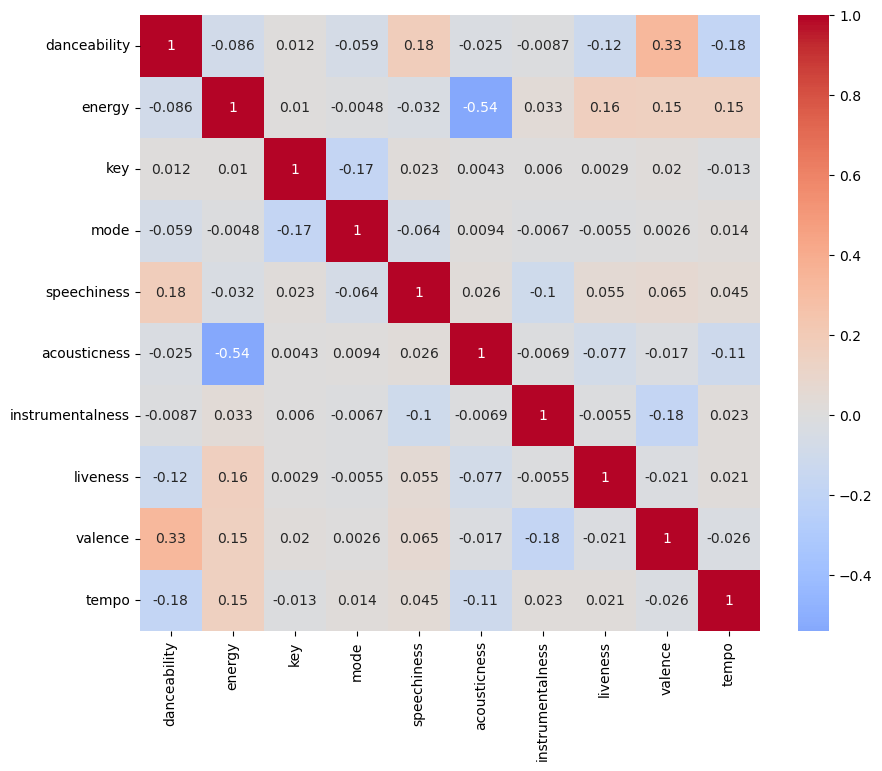

In [34]:
correlation_matrix = scaled_track_feat_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

We see that there are no highly correlated features (the highest being between acousticness and energy).

Now, lets try to find the optimal number of clusters using the elbow method.


In [38]:
wcss = {}
silhouette_scores = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(2, 20):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
        kmeans.fit(X)
        wcss[i] = kmeans.inertia_
        silhouette_scores[i] = silhouette_score(X, kmeans.labels_)

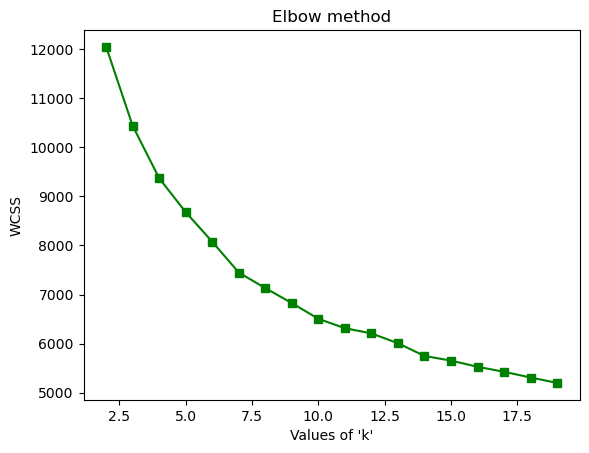

In [39]:
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.title('Elbow method')
plt.show()

           0
2   0.383432
3   0.287046
4   0.219144
5   0.221439
6   0.230354
7   0.239756
8   0.211070
9   0.192553
10  0.196332
11  0.189088
12  0.173691
13  0.160660
14  0.159942
15  0.153449
16  0.156883
17  0.157816
18  0.158782
19  0.158527


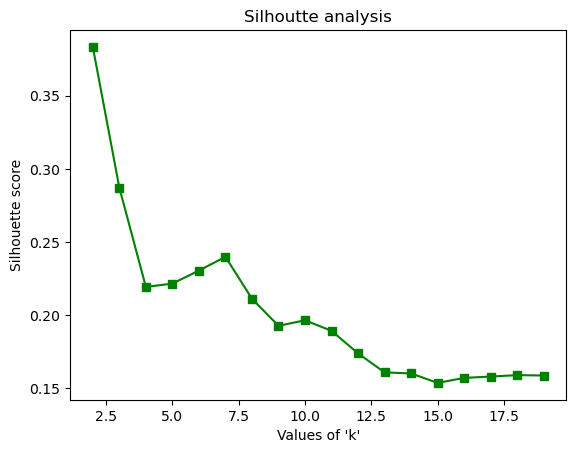

In [44]:
print(pd.DataFrame(silhouette_scores.values(), index=silhouette_scores.keys()))
plt.plot(silhouette_scores.keys(), silhouette_scores.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('Silhouette score')
plt.title('Silhoutte analysis')
plt.show()

From our results we see that even at best (2 clusters) we only get a silhouette score of 0.38. This, along with the lack of a clear elbow suggest that K-Means might not be well suited to our problem. Thus, lets try a different clustering technique, **DBSCAN!**

Before we can implement clustering using DBSCAN, we need to find good values for parameters `eps` and `min_samples`.

For `min_samples` a good heuristic is to try out values between D + 1 and 2 times D or 4 times D where D is the number of dimensions of our data. This would be 11, 20 and 40 in our case.

For `eps` we can plot the k-distance graph, and look for the elbow point.
The k-distance graph is essentially a plot of the distance of each data point from its closest neighbor.

In [45]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances in ascending order
distances = np.sort(distances[:, 1])  # Get distances to 2nd nearest neighbor

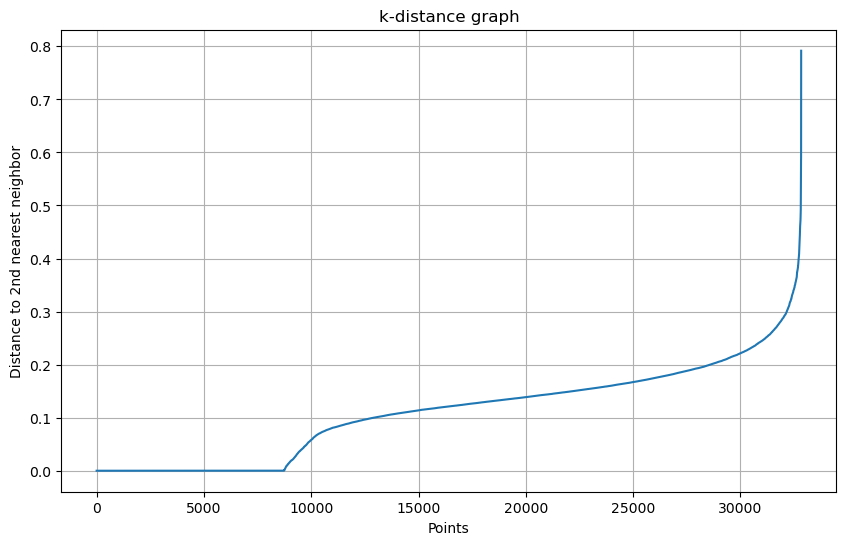

In [46]:
# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points')
plt.ylabel('Distance to 2nd nearest neighbor')
plt.title('k-distance graph')

# Look for the "elbow" in the curve
plt.grid(True)
plt.show()

From the graph we can see that there are two major elbows, around distance values 0.1 and 0.3. These represent density transitions in our data. But 0.3 seems to be too large of a value for eps, as most of the points fall below it, and might lead to merging of clusters. Lets try values around 0.1.

In [ ]:
eps_values = [0.08, 0.1, 0.12, 0.15]
min_samples_values = [11, 15, 20, 25, 30, 35, 40]

num_clusters = {}
num_noise = {}
silhouette_scores = {}

for eps in eps_values:
    print("Current eps:", eps)
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # Skip if all points are noise
        if len(np.unique(labels)) < 2:
            print("All noise for", min_samples)
            continue

        # Calculate metrics
        num_clusters[i] = len(np.unique(labels[labels != -1]))
        num_noise[i] = sum(labels == -1)

        # Calculate silhouette score (excluding noise points)
        if -1 in labels:
            silhouette_scores[i] = silhouette_score(X[labels != -1], 
                                        labels[labels != -1])
        else:
            silhouette_scores[i] = silhouette_score(X, labels)

All noise for 15
All noise for 20
All noise for 25


KeyboardInterrupt: 

In [17]:
print(num_clusters)
print(num_noise)
print(silhouette_scores)

{12: 6, 13: 4}
{12: 32757, 13: 32781}
{12: 0.9144937429178611, 13: 0.8946470408586463}


We can see that an eps value of 0.5 results in most points being classified as noise! Now, lets try 1.5 as our eps.

In [18]:
# With eps = 1.5

num_clusters = {}
num_noise = {}
silhouette_scores = {}

for i in range(12, 23):
    dbscan = DBSCAN(eps=1.5, min_samples=i)
    labels = dbscan.fit_predict(X)

    # Skip if all points are noise
    if len(np.unique(labels)) < 2:
        print("All noise for", i)
        continue

    # Calculate metrics
    num_clusters[i] = len(np.unique(labels[labels != -1]))
    num_noise[i] = sum(labels == -1)

    # Calculate silhouette score (excluding noise points)
    if -1 in labels:
        silhouette_scores[i] = silhouette_score(X[labels != -1], 
                                    labels[labels != -1])
    else:
        silhouette_scores[i] = silhouette_score(X, labels)

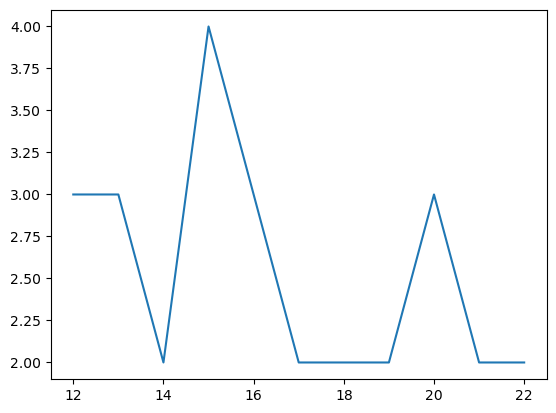

In [20]:
plt.plot(num_clusters.keys(), num_clusters.values())

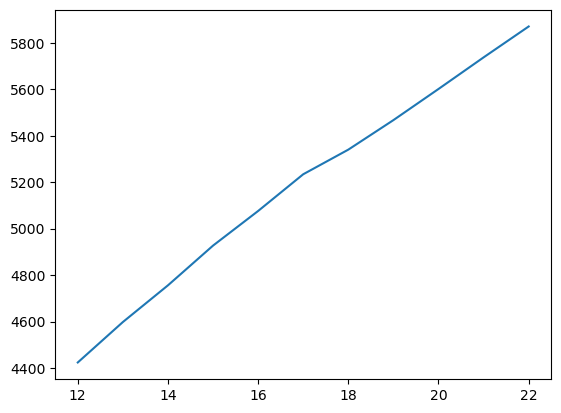

In [21]:
plt.plot(num_noise.keys(), num_noise.values())

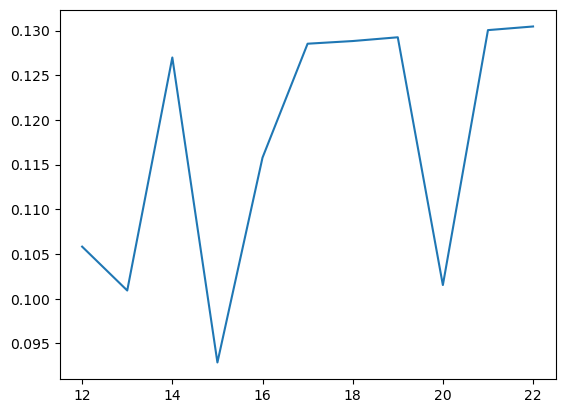

In [22]:
plt.plot(silhouette_scores.keys(), silhouette_scores.values())